### Purpose
Put Alex Ovechkin's massive goal-scoring edge over his peers in context.

We'll do this by scraping (hockey-reference)[hockey-reference.com] for 5-year goal-scoring spans by modifying this URL: https://www.hockey-reference.com/play-index/psl_finder.cgi?request=1&match=combined&year_min=2006&season_start=1&season_end=-1&rookie=N&age_min=0&age_max=99&pos=S&is_playoffs=N&c1stat=goals&c1comp=gt&c1val=300&threshhold=5&order_by=goals

In [1]:
# Start by scraping
import urllib.request
def url_builder(startseason, span = 5):
    parts = ["https://www.hockey-reference.com/play-index/psl_finder.cgi?request=1&match=combined",
             "&year_min={0:d}&year_max={1:d}&season_start=1&season_end=-1&rookie=N&age_min=0&age_max=99".format(
                 startseason, startseason + span - 1),
             "&pos=S&is_playoffs=N&c1stat=goals&c1comp=gt&c1val=100&threshhold=5&order_by=goals"]
    return ''.join(parts)

from os import mkdir
from os.path import exists
if not exists('hr_searches'):
    mkdir('hr_searches')
    
for yr in range(1918, 2014):
    fname = 'hr_searches/{0:d}.html'.format(yr)
    if exists(fname):
        continue
    r = urllib.request.urlopen(url_builder(yr))
    page = r.read()
    r.close()
    w = open(fname, 'w')
    w.write(str(page))
    w.close()
    if yr % 10 == 0:
        print('Done reading/saving {0:d}'.format(yr))

In [2]:
# Now grab the table from each page
from os import listdir
files = listdir('hr_searches')
files = ['hr_searches/{0:s}'.format(x) for x in files]
data = {}
for file in files:
    with open(file, 'r') as r:
        page = r.read()
    data[file] = {}
    
    # Find the table
    try:
        page2 = page[page.index('Query Results Table'):]
    except ValueError:
        print('Could not find query results table in {0:s}; skipping'.format(file))
        continue
    rows = [x.split('<th') for x in page2.split('<tr')]
    rows = rows[3:] # first two rows are blank, then col group headers
    # colnames = [x[x.index('"') + 1:] for x in rows[0] if '"' in x]
    # colnames = [x[:x.index('"')] for x in colnames]
    # data = {c: [] for c in colnames}

    # Just pulling goal totals and names
    for row in rows:
        # print(row[1])
        name = row[1][row[1].index('.html'):]
        name = name[name.index('>')+1:name.index('<')]

        goals = row[1][row[1].index('goals'):]
        goals = int(goals[goals.index('>')+1:goals.index('<')])

        data[file][name] = goals
    # print('Done reading data from {0:s}'.format(file))
import pandas as pd
df = pd.DataFrame(data).reset_index()
df = df.melt(id_vars = 'index', var_name = 'File', value_name = 'Goals').dropna()
df = df.rename(columns = {'index': 'Player'})
df.loc[:, 'Season start'] = df.File.str.extract('.*(\d{4}).html').astype(int) - 1
df.loc[:, 'Season end'] = df['Season start'] + 5
df.head()

Could not find query results table in hr_searches/1935.html; skipping
Could not find query results table in hr_searches/1936.html; skipping


C:\Users\Muneeb Alam\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:38: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


,Player,File,Goals,Season start,Season end
128,Cy Denneny,hr_searches/1918.html,132.0,1917,1922
278,Joe Malone,hr_searches/1918.html,142.0,1917,1922
401,Newsy Lalonde,hr_searches/1918.html,125.0,1917,1922
640,Babe Dye,hr_searches/1919.html,104.0,1918,1923
731,Cy Denneny,hr_searches/1919.html,117.0,1918,1923


In [3]:
# Find the difference between one and the next
df.loc[:, 'Goals_DiffFromPrev'] = df \
    .sort_values(['File', 'Goals'], ascending = [False, True]) \
    .groupby('File', as_index = False) \
    ['Goals'] \
    .transform(lambda x: x.diff()) \
    .iloc[:, 0]
df.loc[:, 'Goals_PctDiffFromPrev'] = df.Goals_DiffFromPrev / df.Goals * 100
df.head()

,Player,File,Goals,Season start,Season end,Goals_DiffFromPrev,Goals_PctDiffFromPrev
128,Cy Denneny,hr_searches/1918.html,132.0,1917,1922,7.0,5.303030
278,Joe Malone,hr_searches/1918.html,142.0,1917,1922,10.0,7.042254
401,Newsy Lalonde,hr_searches/1918.html,125.0,1917,1922,NaN,NaN
640,Babe Dye,hr_searches/1919.html,104.0,1918,1923,2.0,1.923077
731,Cy Denneny,hr_searches/1919.html,117.0,1918,1923,13.0,11.111111


In [4]:
# For the best in each season range, plot
import matplotlib.pyplot as plt
%matplotlib inline
df2 = df \
    .sort_values('Goals', ascending = False) \
    .groupby('File', as_index = False) \
    .first() \
    .drop(['File', 'Goals', 'Goals_DiffFromPrev'], axis = 1)
    
# Plot only when players show up at least 5 times
valid_ps = df2 \
    .assign(Count = 1) \
    .groupby('Player', as_index = False) \
    .count() \
    .query('Count >= 5')
    
df3 = df2.merge(valid_ps[['Player']], how = 'inner', on = 'Player')

Text(0.5,1,'Top NHL regular-season goal scorers, rolling 5-season ranges')

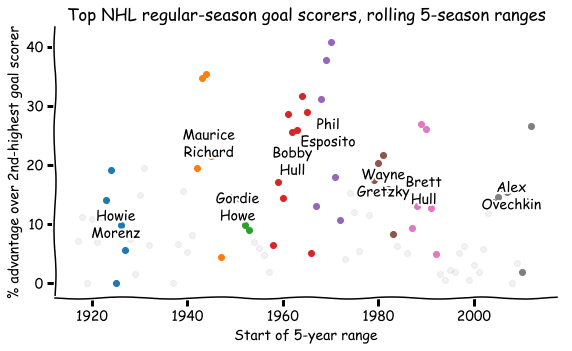

In [5]:
plt.xkcd()
f = plt.figure(figsize = [9, 5])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# First, plot all in background
plt.scatter(df2['Season start'], df2['Goals_PctDiffFromPrev'], color = 'gray', alpha = 0.1)

# Now, plot tops
for p in df3.Player.unique():
    temp = df3[df3.Player == p]
    plt.scatter(temp['Season start'], temp['Goals_PctDiffFromPrev'], label = p)
    # Add player name to group
    center = temp.mean()
    plt.annotate(p.replace(' ', '\n'), 
                 xy = (center['Season start'], center['Goals_PctDiffFromPrev']), 
                 ha = 'center', va = 'center')
    
# plt.legend(loc = 2, bbox_to_anchor=(1, 1))
plt.xlabel('Start of 5-year range')
plt.ylabel('% advantage over 2nd-highest goal scorer')
plt.title('Top NHL regular-season goal scorers, rolling 5-season ranges')